# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [2]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "3.2.0 - 060 recall with zone groups"

pd.set_option("display.max_columns", 500)

path = "../../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to04-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1 - df_train only 2018 without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.fea

## Loading training and validation datasets

In [24]:
df = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_train with nan.feather"))
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

In [25]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [26]:
df.columns

Index(['NUM_SECU_EXPED', 'cond_04', 'cond_05', 'cond_06', 'cond_09', 'cond_11',
       'cond_12', 'cond_32', 'cond_37', 'cond_C1',
       ...
       'cant_sini_1y', 'COD_POST_POLIZA_DP_CLUSTER_2019',
       'COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_POLIZA_RC_CLUSTER_2019',
       'COD_POST_OCURRENCIA_DP_CLUSTER_2019',
       'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
       'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'COD_POST_TERC_DP_CLUSTER_2019',
       'COD_POST_TERC_RT_CLUSTER_2019', 'COD_POST_TERC_RC_CLUSTER_2019'],
      dtype='object', length=157)

In [27]:
pd.crosstab(df["total_condicion"], df["EXISTE_FRAUDE"], normalize=0)

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,0.998269,0.001731
1.0,0.996364,0.003636
2.0,0.977370,0.022630
3.0,0.988867,0.011133
4.0,0.989371,0.010629
5.0,0.803718,0.196282
6.0,0.933239,0.066761
7.0,0.688679,0.311321
8.0,0.717314,0.282686


In [28]:
# Select all non 060 tipo exped.
# 'None': 7,  '003': 2,  '060': 6,  '010': 3,  '020': 4,  '002': 1,  '050': 5,  '001': 0
df = df[df["TIPO_EXPED"] == 6]
df_val = df_val[df_val["TIPO_EXPED"] == 6]

In [29]:
pd.crosstab(df["total_condicion"], df["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,48642,1149
1.0,463,5
2.0,5779,207
3.0,3055,202
4.0,387,26
5.0,891,673
6.0,81,65
7.0,112,99
8.0,85,75


In [30]:
split_date = "2018-12-01"
tmp = df[df["FECHA_SINI"] > split_date].copy()

pd.crosstab(tmp["total_condicion"], tmp["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,3685,60
1.0,338,4
2.0,474,8
3.0,389,18
4.0,17,1
5.0,342,170
6.0,26,17
7.0,59,35
8.0,36,18


In [31]:
df["TIPO_EXPED"].value_counts()

6    62136
Name: TIPO_EXPED, dtype: int64

In [32]:
# delete unique value columns (for tipo_exped == 060)
use_cols = df.nunique()[df.nunique() > 1].index
df = df[use_cols]
df_val = df_val[use_cols]

In [33]:
cond_cols = df.filter(regex="^cond_*").columns
cond_cols

Index(['cond_32', 'cond_C10', 'cond_C11', 'cond_C12', 'cond_C13', 'cond_C14',
       'cond_C15', 'cond_C16', 'cond_C18', 'cond_C19', 'cond_C20'],
      dtype='object')

In [34]:
# create column number of conditions activated
df["cant_cond"] = (df[cond_cols] > 0).sum(axis=1)
df_val["cant_cond"] = (df_val[cond_cols] > 0).sum(axis=1)

In [35]:
df["cant_cond"].value_counts()

0    49791
1    11072
2     1171
3       95
4        7
Name: cant_cond, dtype: int64

In [36]:
df["EXISTE_FRAUDE"].value_counts()

False    59570
True      2566
Name: EXISTE_FRAUDE, dtype: int64

In [37]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [38]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [39]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [40]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2017-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [41]:
# using only last year
split_date = "2018-09-01"
df_train = df[df["FECHA_SINI"] < split_date].copy()
df_opt = df[df["FECHA_SINI"] >= split_date].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2017-01-01 00:00:00 2018-08-31 00:00:00
2018-09-01 00:00:00 2019-01-31 00:00:00


In [42]:
df_train["EXISTE_FRAUDE"].value_counts(normalize=True), df_opt["EXISTE_FRAUDE"].value_counts(normalize=True)

(False    0.962444
 True     0.037556
 Name: EXISTE_FRAUDE, dtype: float64, False    0.945417
 True     0.054583
 Name: EXISTE_FRAUDE, dtype: float64)

In [43]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.780336680829149, 0.21966331917085102)

In [44]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [45]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST", "es_gte_5"] # 

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [46]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [47]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [48]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

48487, 13649
48487, 13649


In [49]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.037556458432157075, 0.05458275331526119)

In [50]:
y_train.value_counts(dropna=False)

False    46666
True      1821
Name: EXISTE_FRAUDE, dtype: int64

## Defining grid configuration

In [51]:
from sklearn.utils.class_weight import compute_class_weight

In [52]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([ 0.52153769, 12.10756041])

In [53]:
# configs
list_weights = [12, 10, 14]
[{0:1, 1:l} for l in list_weights]

[{0: 1, 1: 12}, {0: 1, 1: 10}, {0: 1, 1: 14}]

In [54]:
rf_params = {
    "n_estimators": [60],
    "min_samples_leaf": [3, 5, 7],
    "max_depth": [10, 40], # 10,
    "max_features": ['sqrt', None],
    "class_weight": [{0:1, 1:l} for l in list_weights],
    "bootstrap": [False, True],
}
param_configs = []
# param_configs.append(rf_params)
# param_configs.append(rf_params)

dt_params = {
    "min_samples_leaf": [3, 5, 7],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}
# param_configs.append(dt_params)


gbt_params = {
    'n_estimators': [60, 100], 
#    "min_samples_leaf": [3, 5, 7],
#    "max_depth": [10, 40], # 10,
#    'min_samples_split': [5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bynode": [0.5 , 1],
    "scale_pos_weight": list_weights,
}
param_configs.append(gbt_params)


lgbm_params = {
    'n_estimators': [60, 100], 
#    'num_leaves': [10, 20, 50],
#    'max_depth': [5, 10, 30],
#    'min_child_samples': [3, 5, 7],
    'learning_rate': [1.0, 0.1, 0.01],
#    'subsample': [0.5, 1],
#    "colsample_bytree": [0.5 , 1],
    "class_weight": [{0:1, 1:l} for l in list_weights],
}

param_configs.append(lgbm_params)
param_configs

[{'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'scale_pos_weight': [12, 10, 14]},
 {'n_estimators': [60, 100],
  'learning_rate': [1.0, 0.1, 0.01],
  'class_weight': [{0: 1, 1: 12}, {0: 1, 1: 10}, {0: 1, 1: 14}]}]

In [55]:
# using without grid with list of models
rfs = []
# rfs.append(RandomForestClassifier(random_state=random_state, n_jobs=-1))
# rfs.append(DecisionTreeClassifier(random_state=random_state))
# rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
rfs.append(XGBClassifier(random_state=random_state))
rfs.append(LGBMClassifier(random_state=random_state, silent=False, n_jobs=-1))
rfs

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
               max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
               n_jobs=1, nthread=None, objective='binary:logistic',
               random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
               seed=None, silent=True, subsample=1),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]

In [56]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "recall"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=param_configs[counter], seed=random_state, num_threads=2)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
Comparing 18 parameter setting(s) using 2 CPU thread(s) ( 9 job(s) per thread ).
Best score: 0.7127516778523489
Best config: {'learning_rate': 0.1, 'n_estimators': 100, 'scale_pos_weight': 14}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Model 1: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=Non

In [57]:
print("Best Config:")
for m, s in zip(best_models_, best_scores_):
    print(m, s)

Best Config:
GridSearch(cv_folds=3,
           model=XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=1, gamma=0,
                               learning_rate=0.1, max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               n_estimators=100, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=14,
                               seed=0, silent=True, subsample=1),
           num_threads=2,
           param_grid={'learning_rate': [1.0, 0.1, 0.01],
                       'n_estimators': [60, 100],
                       'scale_pos_weight': [12, 10, 14]},
           seed=42) 0.7127516778523489
GridSearch(cv_folds=3,
           model=LGBMClassifier(boosting_type='gbdt',
                                class_weight={0: 1, 1: 14},
           

In [58]:
# select best grid
best_model = best_models_[np.argmax(best_scores_)]

# select by hand
# best_model = best_models_[1]

In [59]:
sorted_ids = np.argsort(best_model.scores)
print("Grid scores:")
for i in sorted_ids[::-1]:
    print("%0.3f for %r" % (best_model.scores[i], best_model.params[i]))

Grid scores:
0.713 for {'learning_rate': 0.1, 'n_estimators': 100, 'scale_pos_weight': 14}
0.691 for {'learning_rate': 0.1, 'n_estimators': 100, 'scale_pos_weight': 12}
0.683 for {'learning_rate': 0.1, 'n_estimators': 60, 'scale_pos_weight': 14}
0.677 for {'learning_rate': 0.1, 'n_estimators': 100, 'scale_pos_weight': 10}
0.671 for {'learning_rate': 0.1, 'n_estimators': 60, 'scale_pos_weight': 12}
0.659 for {'learning_rate': 0.1, 'n_estimators': 60, 'scale_pos_weight': 10}
0.630 for {'learning_rate': 0.01, 'n_estimators': 100, 'scale_pos_weight': 14}
0.630 for {'learning_rate': 0.01, 'n_estimators': 100, 'scale_pos_weight': 10}
0.630 for {'learning_rate': 0.01, 'n_estimators': 60, 'scale_pos_weight': 12}
0.630 for {'learning_rate': 0.01, 'n_estimators': 60, 'scale_pos_weight': 10}
0.630 for {'learning_rate': 0.01, 'n_estimators': 60, 'scale_pos_weight': 14}
0.630 for {'learning_rate': 0.01, 'n_estimators': 100, 'scale_pos_weight': 12}
0.430 for {'learning_rate': 1.0, 'n_estimators': 10

In [60]:
best_model.best_estimator_.fit(X_full_train, y_full_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=14,
              seed=0, silent=True, subsample=1)

In [61]:
y_val_pred = best_model.best_estimator_.predict_proba(X_val)[:, 1]
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred > 0.5), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4627720504009164, 0.905639332526028)

In [62]:
confusion_matrix(y_val, y_val_pred> 0.5)

array([[4462,  401],
       [  68,  202]])

**old**

Best model:


In [62]:
y_val_pred = best_model.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.29571106094808125, 0.6927262549409371)

In [63]:
confusion_matrix(y_val, y_val_pred)

array([[4378,  485],
       [ 139,  131]])

**Tronador**

In [78]:
y_val_tron = X_val["total_condicion"] >= 5
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI = f1_score(y_val, y_val_tron), roc_auc_score(y_val, y_val_tron)
y_val_tron_f1_bestFI, y_val_tron_rocauc_bestFI

(0.470873786407767, 0.8222450704868967)

In [79]:
confusion_matrix(y_val, y_val_tron)

array([[4503,  360],
       [  76,  194]])

In [81]:
df_val_an = df_val.copy()

In [82]:
df_val_an["y_pred"] = y_val_pred

In [84]:
pd.crosstab(df_val_an["EXISTE_INVEST"], [df_val_an["EXISTE_FRAUDE"], df_val_an["y_pred"] > 0.5])

EXISTE_FRAUDE False       True       
y_pred        False True  False True 
EXISTE_INVEST                        
-1             4444    17     0     0
 0               26   233     0     1
 1               51    92    79   190

In [92]:
df_val_an[(df_val_an["y_pred"] > 0.45) & (df_val_an["total_condicion"] < 5)]

,NUM_SECU_EXPED,cond_32,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C18,cond_C19,cond_C20,total_condicion,es_gte_5,EXISTE_FRAUDE,EXISTE_INVEST,preg_15,preg_31,preg_32,preg_33,preg_34,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_RAMO_sini,COD_RIES_sini,DESCRIPCION_TIPO,ESTADO_CIVIL,ESTAD_VEH_ASEG,FALTANTE,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,NUM_SECU_POL,OCUPACION_ASEG,SEXO,TIPO,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Elapsed,cant_pol,cant_sini_1y,COD_POST_POLIZA_DP_CLUSTER_2019,COD_POST_POLIZA_RT_CLUSTER_2019,COD_POST_POLIZA_RC_CLUSTER_2019,COD_POST_OCURRENCIA_DP_CLUSTER_2019,COD_POST_OCURRENCIA_RT_CLUSTER_2019,COD_POST_OCURRENCIA_RC_CLUSTER_2019,cant_cond,y_pred
30885,1927722409999,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,False,False,-1,-1,0,0,1,504,0,0,0,-1.0,-1.0,-1.0,666.0,209.0,1875.0,1875.0,1.0,1.0,2,6,2.0,1,0,-1,1,1,1.917249e+12,5.0,1,6.0,-1,-1,5,1.0,0.0,1.0,8,3013,6419,5,-1,5660.0,1.0,1.0,1.0,107,-1.0,0,0,0,1,-1,0,5,0,0.0,-1,-1,-1,-1,-1.0,-1,2019.0,3.0,9.0,1.0,4.0,60.0,0.0,1.0,0.0,0.0,0.0,0.0,1551398400,0.0,0.0,22.0,8.0,25.0,22.0,8.0,25.0,1,0.462423


In [66]:
tmp = df_val_an[df_val_an["total_condicion"] == 0]
tmp.head()

,NUM_SECU_EXPED,cond_32,cond_C10,cond_C11,cond_C12,cond_C13,cond_C14,cond_C15,cond_C16,cond_C18,cond_C19,cond_C20,total_condicion,es_gte_5,EXISTE_FRAUDE,EXISTE_INVEST,preg_15,preg_31,preg_32,preg_33,preg_34,CERRADURA_BAUL,CERRADURA_DERECHA,CERRADURA_IZQUIERDA,CODIGO_BAJA,CODIGO_CARATULA,CODIGO_REAPERTURA,CODIGO_VEHICULO,COD_CAUSA_SINI,COD_POST_OCURRENCIA,COD_POST_POLIZA,COD_RAMO_sini,COD_RIES_sini,DESCRIPCION_TIPO,ESTADO_CIVIL,ESTAD_VEH_ASEG,FALTANTE,MCA_COASEG,MCA_JUICIO,MCA_VIP,METRO,NUM_SECU_POL,OCUPACION_ASEG,SEXO,TIPO,TIPO_LESION,TIPO_LESION_MAXIMA,TIPO_SINIESTRO,USO,dias_entre_denu_y_sini,CANT_RENOVACION,CAPITAL_ACCESORIOS,CAPITAL_ASEGURADO_COTIZACION,CAPITAL_VEHICULO,COD_COBRO,COD_COBRO_ANTERIOR,COD_PROD,COD_ZONA_CASCO,COD_ZONA_RC,COD_ZONA_ROBO,CONV_COMISIONARIO,CIF_ID,MCA_AGRAVANTE,MCA_EMPLEADO,MCA_MOVIMIENTO,MCA_POLIZA_VIP,NEGOCIO,PRENDARIO,SEGMENTO,cambio_cobro,ANTIG_pol,TIPO_ACTIVIDAD,CLIENTE,CODIGO_NACION,DATECO_TIPO_ACTIVIDAD,DOMICILIO_CODIGO_POSTAL,HABILITADO,FECHA_SINI_Year,FECHA_SINI_Month,FECHA_SINI_Week,FECHA_SINI_Day,FECHA_SINI_Dayofweek,FECHA_SINI_Dayofyear,FECHA_SINI_Is_month_end,FECHA_SINI_Is_month_start,FECHA_SINI_Is_quarter_end,FECHA_SINI_Is_quarter_start,FECHA_SINI_Is_year_end,FECHA_SINI_Is_year_start,FECHA_SINI_Elapsed,cant_pol,cant_sini_1y,COD_POST_POLIZA_DP_CLUSTER_2019,COD_POST_POLIZA_RT_CLUSTER_2019,COD_POST_POLIZA_RC_CLUSTER_2019,COD_POST_OCURRENCIA_DP_CLUSTER_2019,COD_POST_OCURRENCIA_RT_CLUSTER_2019,COD_POST_OCURRENCIA_RC_CLUSTER_2019,cant_cond,y_pred
10,1916898249999,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,-1,-1,0,0,1,-1,0,0,0,-1.0,-1.0,-1.0,12718.0,209.0,1676.0,1712.0,1.0,1.0,3,0,5.0,1,0,-1,1,1,1.900647e+12,5.0,1,3.0,-1,-1,7,1.0,0.0,16.0,8,3270,6799,5,5,5660.0,1.0,1.0,1.0,107,1054183.0,0,0,-1,1,21,0,5,0,457.0,88,-1,2,40,1712000.0,1,2019.0,2.0,5.0,1.0,4.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,1548979200,1.0,3.0,25.0,8.0,26.0,27.0,6.0,24.0,0,0.181835
15,1916898859999,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,-1,-1,0,0,0,270,0,0,0,-1.0,-1.0,-1.0,12718.0,209.0,1766.0,1752.0,8.0,1.0,3,0,5.0,1,0,-1,1,1,1.903457e+12,5.0,1,3.0,-1,-1,5,1.0,0.0,28.0,8,2990,6434,2,2,74322.0,1.0,1.0,1.0,42,-1.0,1,0,-1,1,47,1,-1,0,803.0,-1,-1,-1,-1,-1.0,-1,2019.0,2.0,5.0,1.0,4.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,1548979200,0.0,0.0,29.0,10.0,25.0,29.0,10.0,25.0,0,0.208060
17,1916899449999,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,-1,-1,0,0,1,-1,0,0,0,-1.0,-1.0,-1.0,12716.0,209.0,1425.0,1881.0,1.0,1.0,3,0,3.0,1,0,-1,0,1,1.894863e+12,1.0,1,3.0,-1,-1,5,1.0,0.0,7.0,75,2323,4763,5,5,6010.0,1.0,1.0,2.0,107,-1.0,0,0,-1,0,21,0,4,0,184.0,-1,-1,-1,-1,-1.0,-1,2019.0,2.0,5.0,1.0,4.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,1548979200,0.0,0.0,23.0,7.0,24.0,12.0,5.0,16.0,0,0.077313
22,1916900799999,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,-1,-1,0,0,0,-1,0,0,0,-1.0,-1.0,-1.0,27636.0,209.0,4728.0,4000.0,1.0,1.0,23,0,3.0,1,0,-1,1,0,1.855151e+12,44.0,1,8.0,-1,-1,5,1.0,0.0,1.0,8,3480,7713,2,2,72038.0,2.0,4.0,9.0,16,-1.0,1,0,-1,1,47,1,5,0,0.0,-1,-1,-1,-1,-1.0,-1,2019.0,2.0,5.0,1.0,4.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,1548979200,0.0,0.0,13.0,3.0,13.0,2.0,1.0,2.0,0,0.128247
52,1916910359999,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,-1,-1,0,0,0,270,0,0,0,-1.0,-1.0,-1.0,19029.0,209.0,1684.0,1722.0,1.0,1.0,3,6,3.0,1,0,-1,1,1,1.888810e+12,9999.0,0,3.0,-1,-1,5,1.0,0.0,32.0,8,669,1016,5,5,5660.0,1.0,1.0,4.0,107,-1.0,0,0,-1,1,21,0,5,0,944.0,-1,-1,-1,-1,-1.0,-1,2019.0,2.0,5.0,1.0,4.0,32.0,0.0,1.0,0.0,0.0,0.0,0.0,1548979200,0.0,0.0,25.0,8.0,28.0,25.0,8.0,26.0,0,0.137445


## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worse</h3>

In [63]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':best_model.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
11,total_condicion,0.064422
1,cond_C10,0.062958
23,CODIGO_VEHICULO,0.045388
22,CODIGO_REAPERTURA,0.043924
16,preg_34,0.042460
25,COD_POST_OCURRENCIA,0.039531
26,COD_POST_POLIZA,0.038067
37,OCUPACION_ASEG,0.036603
92,COD_POST_OCURRENCIA_RC_CLUSTER_2019,0.033675
84,FECHA_SINI_Elapsed,0.033675


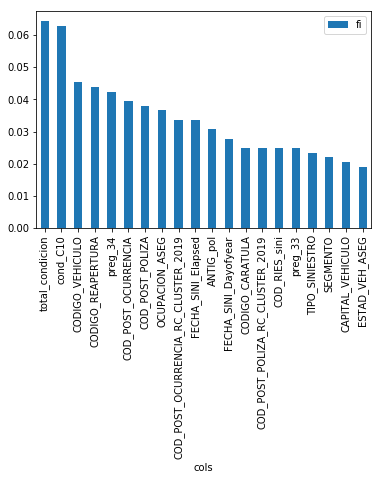

In [64]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [65]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 45 of 94


In [103]:
"""to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "COD_CAUSA_SINI", 
            ] # "es_gte_5", "total_condicion", 

for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep"""

'to_remove = [\'COD_POST_POLIZA_RT_CLUSTER_2019\', \'COD_POST_OCURRENCIA_RT_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_RC_CLUSTER_2019\',  \'COD_POST_POLIZA_RC_CLUSTER_2019\',\n             \'COD_POST_OCURRENCIA_DP_CLUSTER_2019\', \'COD_POST_POLIZA_DP_CLUSTER_2019\',\n             "COD_CAUSA_SINI", \n            ] # "es_gte_5", "total_condicion", \n\nfor col in to_remove:\n    if(col in to_keep):\n        to_keep.remove(col)\nto_keep'

In [66]:
# best model
clf.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [67]:
X_train_red = X_train[to_keep].copy()

In [68]:
print(len(X_train_red.columns))

45


### Training again with less features

In [69]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [71]:
y_opt_pred = rf.predict(X_opt[to_keep])
y_opt_f1_bestFI, y_opt_rocauc_bestFI = f1_score(y_opt, y_opt_pred), roc_auc_score(y_opt, y_opt_pred)
y_opt_f1_bestFI, y_opt_rocauc_bestFI

(0.39442980805419653, 0.7978960792553789)

In [72]:
confusion_matrix(y_opt, y_opt_pred)

array([[11516,  1388],
       [  221,   524]])

In [73]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
2,CODIGO_VEHICULO,120
10,ANTIG_pol,119
9,FECHA_SINI_Elapsed,108
5,COD_POST_OCURRENCIA,106
18,CAPITAL_VEHICULO,92
11,FECHA_SINI_Dayofyear,72
22,CAPITAL_ASEGURADO_COTIZACION,71
21,COD_PROD,71
6,COD_POST_POLIZA,69
4,preg_34,65


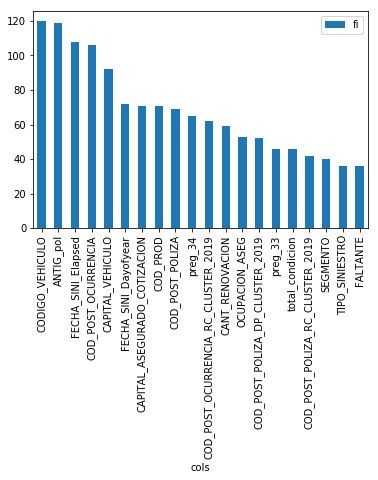

In [74]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [75]:
best_model = copy(rf)

In [ ]:
# best columns used
rf_fi["cols"].values

# model with validation set

## full features final model

In [77]:
rf_full = copy(best_model)
rf_full.fit(X_full_train, y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [78]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.468, 0.905


In [79]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4475,  388],
       [  69,  201]])

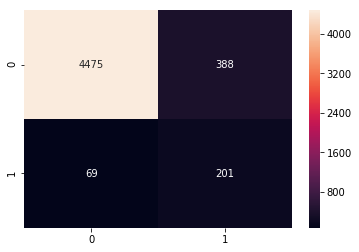

In [80]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [84]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

LGBMClassifier(boosting_type='gbdt', class_weight={0: 1, 1: 14},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=60, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=False, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [85]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
metric_results = "%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI)
print(metric_results)

0.471, 0.898


In [86]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[4477,  386],
       [  68,  202]])

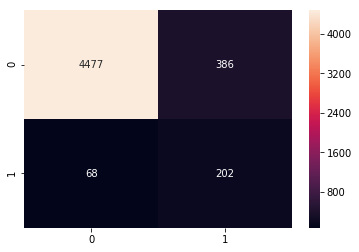

In [87]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [81]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.470873786407767,0.8222450704868967)


In [82]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[4503,  360],
       [  76,  194]])

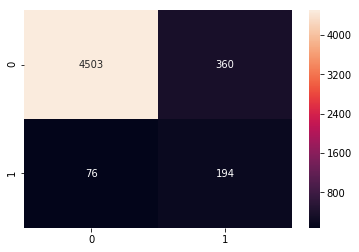

In [83]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [88]:
path_to_save = f"models/{model_id}/"
os.makedirs(path_to_save, exist_ok=True)

In [89]:
model_file = os.path.join(path_to_save, f"{model_id}.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, pickle.HIGHEST_PROTOCOL)

In [90]:
# save file for humans
model_file = os.path.join(path_to_save, f"{model_id} - readable.pickle")

with open(model_file, "wb") as f:
    pickle.dump(best_model, f, 0) # 0 is human readable format

In [91]:
# merging list input & target
full_cols = list(to_keep)  # + ["EXISTE_FRAUDE"]
print(full_cols)

['total_condicion', 'cond_C10', 'CODIGO_VEHICULO', 'CODIGO_REAPERTURA', 'preg_34', 'COD_POST_OCURRENCIA', 'COD_POST_POLIZA', 'OCUPACION_ASEG', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'FECHA_SINI_Elapsed', 'ANTIG_pol', 'FECHA_SINI_Dayofyear', 'CODIGO_CARATULA', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'COD_RIES_sini', 'preg_33', 'TIPO_SINIESTRO', 'SEGMENTO', 'CAPITAL_VEHICULO', 'ESTAD_VEH_ASEG', 'ESTADO_CIVIL', 'COD_PROD', 'CAPITAL_ASEGURADO_COTIZACION', 'preg_15', 'FALTANTE', 'CANT_RENOVACION', 'CAPITAL_ACCESORIOS', 'DESCRIPCION_TIPO', 'preg_32', 'COD_ZONA_ROBO', 'SEXO', 'cond_C15', 'cant_sini_1y', 'cond_C11', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'COD_COBRO_ANTERIOR', 'COD_RAMO_sini', 'FECHA_SINI_Week', 'FECHA_SINI_Month', 'COD_ZONA_RC', 'cond_C12', 'cond_C13', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'preg_31']


In [92]:
columns_file = os.path.join(path_to_save, f"{model_id} (COLUMNS) - n_features_{len(full_cols)}.pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [120]:
# saving to use as example a few rows to implement the model
# path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
# sample_file = os.path.join(path_to_save, f"{model_id} (sample)  - dataset example to predict model.csv")

# df_example = X_val.loc[:, to_keep][-50:]
# df_example["EXISTE_FRAUDE"] = y_val[-50:]
# df_example.to_csv(sample_file)

In [ ]:
# df_example.head()

# Test prediction

In [3]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

In [4]:
df_test = df_test[df_test["TIPO_EXPED"] == 6]

In [95]:
# Loding the model

def load_model(model_file):
    """Load the dump model."""
    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [96]:
m = load_model(model_file)
columns = load_columns(columns_file)

In [97]:
print(columns)

['total_condicion', 'cond_C10', 'CODIGO_VEHICULO', 'CODIGO_REAPERTURA', 'preg_34', 'COD_POST_OCURRENCIA', 'COD_POST_POLIZA', 'OCUPACION_ASEG', 'COD_POST_OCURRENCIA_RC_CLUSTER_2019', 'FECHA_SINI_Elapsed', 'ANTIG_pol', 'FECHA_SINI_Dayofyear', 'CODIGO_CARATULA', 'COD_POST_POLIZA_RC_CLUSTER_2019', 'COD_RIES_sini', 'preg_33', 'TIPO_SINIESTRO', 'SEGMENTO', 'CAPITAL_VEHICULO', 'ESTAD_VEH_ASEG', 'ESTADO_CIVIL', 'COD_PROD', 'CAPITAL_ASEGURADO_COTIZACION', 'preg_15', 'FALTANTE', 'CANT_RENOVACION', 'CAPITAL_ACCESORIOS', 'DESCRIPCION_TIPO', 'preg_32', 'COD_ZONA_ROBO', 'SEXO', 'cond_C15', 'cant_sini_1y', 'cond_C11', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019', 'COD_COBRO_ANTERIOR', 'COD_RAMO_sini', 'FECHA_SINI_Week', 'FECHA_SINI_Month', 'COD_ZONA_RC', 'cond_C12', 'cond_C13', 'COD_POST_POLIZA_RT_CLUSTER_2019', 'preg_31']


In [98]:
X_test = df_test[columns]
y_test = df_test["EXISTE_FRAUDE"]

In [99]:
X_test.head()

,total_condicion,cond_C10,CODIGO_VEHICULO,CODIGO_REAPERTURA,preg_34,COD_POST_OCURRENCIA,COD_POST_POLIZA,OCUPACION_ASEG,COD_POST_OCURRENCIA_RC_CLUSTER_2019,FECHA_SINI_Elapsed,ANTIG_pol,FECHA_SINI_Dayofyear,CODIGO_CARATULA,COD_POST_POLIZA_RC_CLUSTER_2019,COD_RIES_sini,preg_33,TIPO_SINIESTRO,SEGMENTO,CAPITAL_VEHICULO,ESTAD_VEH_ASEG,ESTADO_CIVIL,COD_PROD,CAPITAL_ASEGURADO_COTIZACION,preg_15,FALTANTE,CANT_RENOVACION,CAPITAL_ACCESORIOS,DESCRIPCION_TIPO,preg_32,COD_ZONA_ROBO,SEXO,cond_C15,cant_sini_1y,cond_C11,COD_POST_OCURRENCIA_RT_CLUSTER_2019,COD_POST_POLIZA_DP_CLUSTER_2019,COD_COBRO_ANTERIOR,COD_RAMO_sini,FECHA_SINI_Week,FECHA_SINI_Month,COD_ZONA_RC,cond_C12,cond_C13,COD_POST_POLIZA_RT_CLUSTER_2019,preg_31
11,2.0,0.0,12415.0,-1.0,270,5010.0,5010.0,5.0,18.0,1554076800,455.0,91.0,-1.0,18.0,1.0,1,5,4,1324,3.0,6,5010.0,778,-1,0,16.0,8,3,1,7.0,1,0.0,0.0,0.0,3.0,19.0,0,1.0,14.0,4.0,8.0,0.0,0.0,3.0,0
13,2.0,0.0,21763.0,-1.0,-1,1759.0,1759.0,28.0,25.0,1554076800,608.0,91.0,-1.0,25.0,1.0,1,5,4,424,3.0,6,6030.0,317,-1,1,21.0,8,3,1,1.0,1,0.0,0.0,0.0,10.0,29.0,5,1.0,14.0,4.0,1.0,0.0,0.0,10.0,1
23,5.0,0.0,2035.0,-1.0,293,1754.0,1766.0,8.0,25.0,1554076800,1034.0,91.0,-1.0,25.0,1.0,1,7,4,2781,3.0,6,6030.0,1475,-1,0,35.0,182,2,1,1.0,1,0.0,0.0,0.0,10.0,29.0,5,1.0,14.0,4.0,1.0,3.0,0.0,10.0,0
24,3.0,0.0,2116.0,-1.0,270,1766.0,1766.0,5.0,25.0,1554076800,676.0,91.0,-1.0,25.0,1.0,0,5,-1,5618,5.0,0,72189.0,2818,-1,1,24.0,8,3,0,1.0,1,0.0,0.0,0.0,10.0,29.0,2,8.0,14.0,4.0,1.0,3.0,0.0,10.0,0
30,0.0,0.0,28512.0,-1.0,270,5000.0,5000.0,13.0,18.0,1554076800,516.0,91.0,-1.0,18.0,1.0,1,5,5,7555,3.0,9,72043.0,3534,-1,1,18.0,8,23,0,7.0,1,0.0,1.0,0.0,3.0,19.0,2,1.0,14.0,4.0,8.0,0.0,0.0,3.0,0


## Model in test

In [100]:
# using trained model
y_test_pred_prob = m.predict_proba(X_test)[:, -1]

# Using load model
# y_test_pred_prob = m.predict_proba(X_test)[:, -1]

print("%.3f, %.3f" % (f1_score(y_test, y_test_pred_prob > 0.5), roc_auc_score(y_test, y_test_pred_prob)))

0.393, 0.893


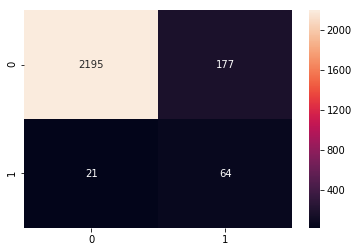

In [127]:
conf_mat = confusion_matrix(y_test, y_test_pred_prob > 0.5)
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador in test

In [128]:
y_tronador = df_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))

0.444, 0.842


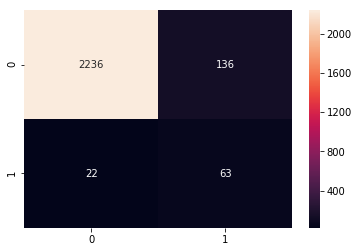

In [129]:
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

In [5]:
pd.crosstab(df_test["total_condicion"],df_test["EXISTE_FRAUDE"])

EXISTE_FRAUDE,False,True
total_condicion,,
0.0,1595,10
1.0,134,1
2.0,239,1
3.0,251,10
4.0,17,0
5.0,80,30
6.0,23,5
7.0,3,3
8.0,15,6
